# GraphML Session 03


## OSM Analysis

Here we'll add weights to our graph based on nearby amenities as described in Open Street Maps.

In [1]:
!pip install osmnx

In [1]:
import networkx as nx
import osmnx as ox
import pandas as pd
import numpy as np
from collections import Counter

%matplotlib inline
import matplotlib.pyplot as plt

 Divide the City into Grid Cells

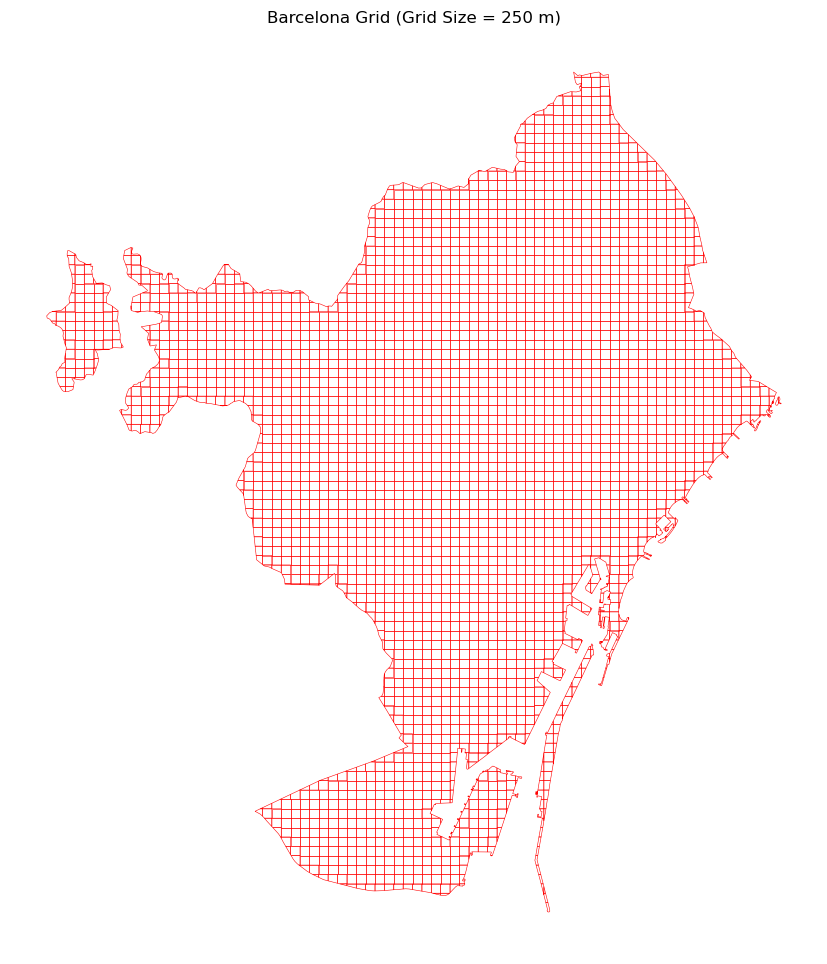

In [11]:
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
import numpy as np

# Get city boundary
barcelona = ox.geocode_to_gdf("Barcelona, Spain").to_crs(epsg=3857)

# Grid size in meters – change this value to test
grid_size = 250  # Try 150, 200, etc.

# Generate grid
minx, miny, maxx, maxy = barcelona.total_bounds
cells = []
for x in np.arange(minx, maxx, grid_size):
    for y in np.arange(miny, maxy, grid_size):
        cells.append(box(x, y, x + grid_size, y + grid_size))
grid = gpd.GeoDataFrame(geometry=cells, crs=barcelona.crs)
grid = gpd.overlay(grid, barcelona, how="intersection")
grid["cell_id"] = range(len(grid))
# Plot the grid only
fig, ax = plt.subplots(figsize=(12, 12))
grid.plot(ax=ax, edgecolor="red", facecolor="none", linewidth=0.4)
plt.title(f"Barcelona Grid (Grid Size = {grid_size} m)")
plt.axis("off")
plt.show()


Tilted grid to match Eixample

C:\Users\DELL\AppData\Local\Temp\ipykernel_33024\3216475066.py:18: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  cx, cy = barcelona.geometry.unary_union.centroid.coords[0]


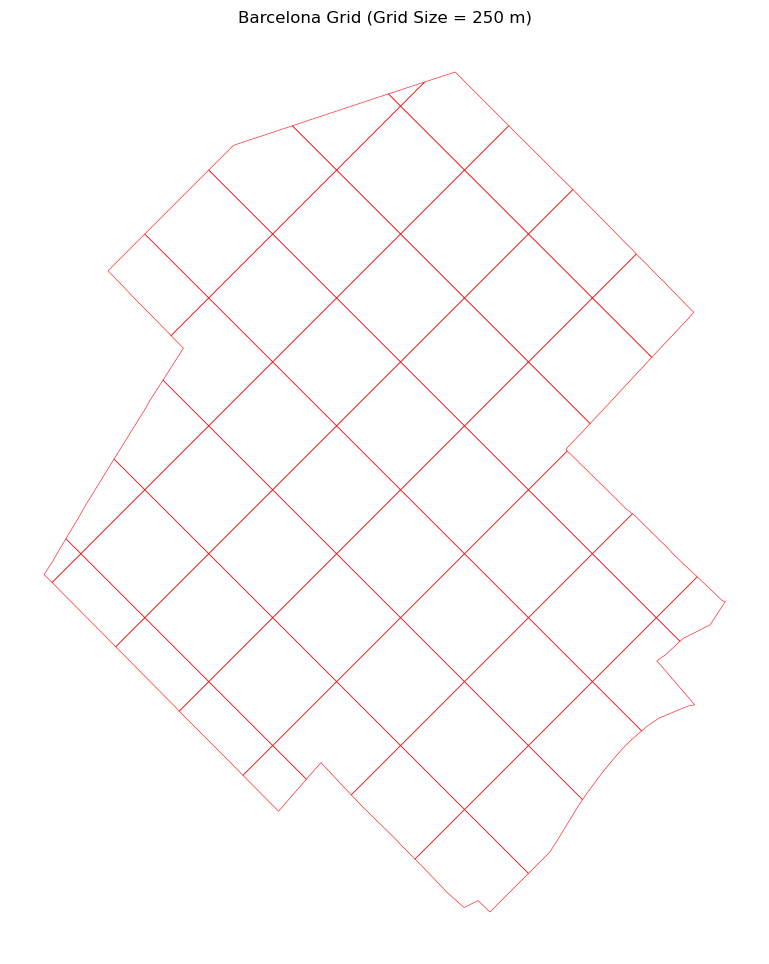

In [32]:
from shapely import affinity

# 1. Define the rotation angle (in degrees)
rotation_angle = -45  # Eixample tilt is ~30° clockwise → -30 to rotate clockwise
# Get city boundary
barcelona = ox.geocode_to_gdf("Poblenou, Barcelona, Spain").to_crs(epsg=3857)
# 2. Generate the grid
grid_size = 250  # Use Eixample-like block size
minx, miny, maxx, maxy = barcelona.total_bounds
cells = []

for x in np.arange(minx, maxx, grid_size):
    for y in np.arange(miny, maxy, grid_size):
        cell = box(x, y, x + grid_size, y + grid_size)
        cells.append(cell)

# 3. Apply rotation around the center of the city
cx, cy = barcelona.geometry.unary_union.centroid.coords[0]
rotated_cells = [affinity.rotate(cell, rotation_angle, origin=(cx, cy)) for cell in cells]

# 4. Create GeoDataFrame and clip
grid = gpd.GeoDataFrame(geometry=rotated_cells, crs=barcelona.crs)
grid = gpd.overlay(grid, barcelona, how="intersection")
grid["cell_id"] = range(len(grid))
# Plot the grid only
fig, ax = plt.subplots(figsize=(12, 12))
grid.plot(ax=ax, edgecolor="red", facecolor="none", linewidth=0.4)
plt.title(f"Barcelona Grid (Grid Size = {grid_size} m)")
plt.axis("off")
plt.show()


Download Streets + Buildings for Background

In [20]:
# Download streets and building footprints
G = ox.graph_from_place("Poblenou, Barcelona, Spain", network_type="drive")
streets = ox.graph_to_gdfs(G, nodes=False, edges=True).to_crs(epsg=3857)
buildings = ox.features_from_place("Poblenou,Barcelona, Spain", tags={"building": True})



 Plot Everything Together

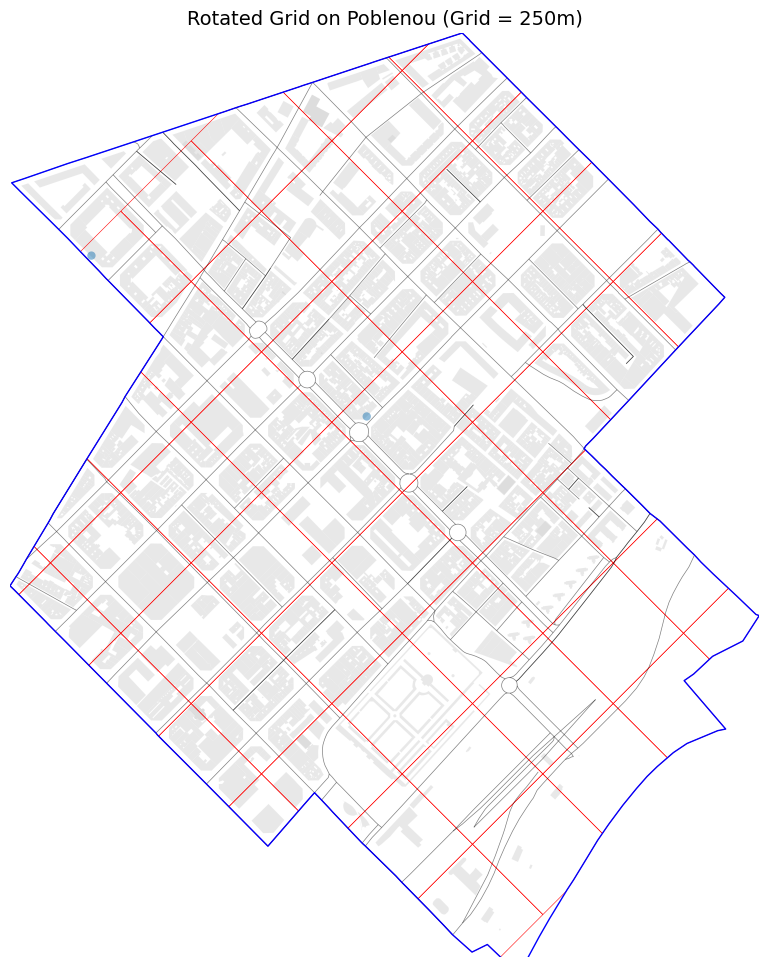

In [33]:
# Reproject buildings to match grid
buildings = buildings.to_crs(epsg=3857)
# Plot everything
fig, ax = plt.subplots(figsize=(12, 12))
streets.plot(ax=ax, linewidth=0.5, color="black", alpha=0.5)
buildings.plot(ax=ax, facecolor="lightgray", edgecolor="none", alpha=0.5)
grid.plot(ax=ax, facecolor="none", edgecolor="red", linewidth=0.4)
barcelona.boundary.plot(ax=ax, edgecolor="blue", linewidth=1)

# Zoom into the actual grid area
ax.set_xlim(grid.total_bounds[0], grid.total_bounds[2])
ax.set_ylim(grid.total_bounds[1], grid.total_bounds[3])
ax.set_aspect("equal")

plt.title(f"Rotated Grid on Poblenou (Grid = {grid_size}m)", fontsize=14)
plt.axis("off")
plt.show()

##GridGenerator Class

In [35]:
import osmnx as ox
import geopandas as gpd
from shapely.geometry import box
from shapely import affinity
import numpy as np

class RotatedGridGenerator:
    def __init__(self, place_name, grid_size=113, rotation_angle=-45):
        """
        place_name: str - the name of the location (e.g. "Poblenou, Barcelona, Spain")
        grid_size: int - the grid cell size in meters (width = height)
        rotation_angle: float - clockwise rotation in degrees (e.g., -45)
        """
        self.place_name = place_name
        self.grid_size = grid_size
        self.rotation_angle = rotation_angle
        self.city_boundary = self._get_boundary()
        self.crs = self.city_boundary.crs
        self.grid = self._generate_rotated_grid()

    def _get_boundary(self):
        """Download and return the city or neighborhood boundary"""
        return ox.geocode_to_gdf(self.place_name).to_crs(epsg=3857)

    def _generate_rotated_grid(self):
        """Create a rotated square grid clipped to the city boundary"""
        minx, miny, maxx, maxy = self.city_boundary.total_bounds
        cells = []
        for x in np.arange(minx, maxx, self.grid_size):
            for y in np.arange(miny, maxy, self.grid_size):
                cell = box(x, y, x + self.grid_size, y + self.grid_size)
                cells.append(cell)

        # Rotate grid around city center
        cx, cy = self.city_boundary.geometry.unary_union.centroid.coords[0]
        rotated_cells = [affinity.rotate(cell, self.rotation_angle, origin=(cx, cy)) for cell in cells]

        grid = gpd.GeoDataFrame(geometry=rotated_cells, crs=self.crs)
        grid = gpd.overlay(grid, self.city_boundary, how="intersection")
        grid["cell_id"] = range(len(grid))
        return grid

    def get_grid(self):
        """Return the rotated clipped grid as a GeoDataFrame"""
        return self.grid

    def plot(self, ax=None, **kwargs):
        """Quick visualization of the grid"""
        if ax is None:
            import matplotlib.pyplot as plt
            fig, ax = plt.subplots(figsize=(10, 10))
        self.city_boundary.boundary.plot(ax=ax, edgecolor="blue")
        self.grid.plot(ax=ax, edgecolor="red", facecolor="none", **kwargs)
        ax.set_title(f"Rotated Grid on {self.place_name} (size={self.grid_size}m, angle={self.rotation_angle}°)")
        ax.set_axis_off()
        ax.set_aspect("equal")
        return ax


C:\Users\DELL\AppData\Local\Temp\ipykernel_33024\2233986745.py:35: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  cx, cy = self.city_boundary.geometry.unary_union.centroid.coords[0]


<Axes: title={'center': 'Rotated Grid on Poblenou, Barcelona, Spain (size=226m, angle=-45°)'}>

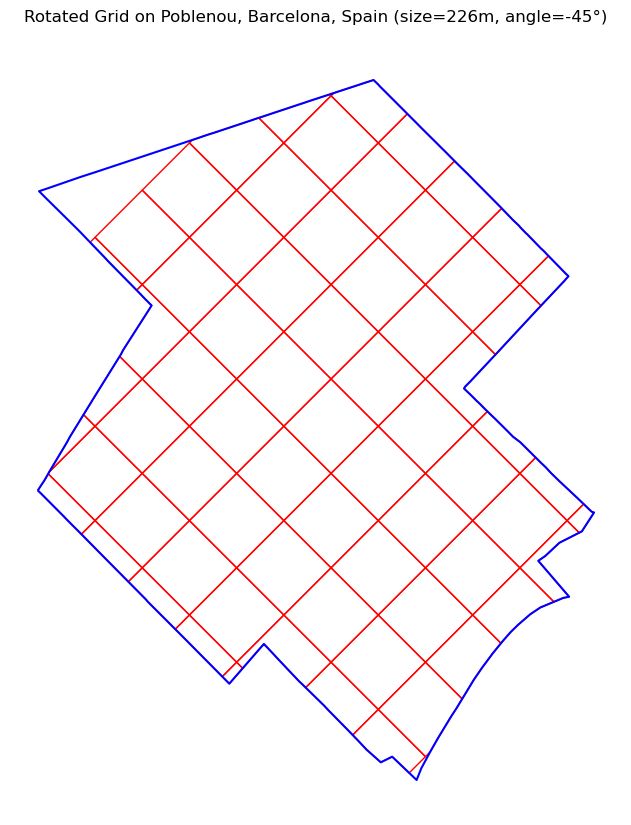

In [36]:
# Create a grid over Poblenou, with 2x2 blocks per cell (~226m), rotated 45°
gridgen = RotatedGridGenerator("Poblenou, Barcelona, Spain", grid_size=226, rotation_angle=-45)

# Get the grid as GeoDataFrame
grid = gridgen.get_grid()

# Plot it
gridgen.plot()


##AMENITIES

We start by gettin a location:

In [37]:
place_name = "Poblenou, Barcelona, Spain"
G = ox.graph_from_place(place_name, network_type="drive")


Next, we define what kind of "amenities" do we want to extract from OSM.

Key values to look for refer to https://wiki.openstreetmap.org/wiki/Map_Features


In [38]:
# set value to True for all values pairable to the key
key = "amenity"
value = ["bar","restaurant","pub","cafe","fast_food"]

# Download the Points of interest
tags = {key: value}
gdf = ox.features_from_place(place_name, tags=tags)
gdf

geometry  \
element id                                                              
node    660100527                            POINT (2.19677 41.40469)   
        660100529                            POINT (2.19419 41.40486)   
        660771772                             POINT (2.19776 41.4035)   
        660778771                             POINT (2.19865 41.4029)   
        660784487                             POINT (2.1989 41.40273)   
...                                                               ...   
way     217583616   POLYGON ((2.2063 41.39474, 2.20638 41.39468, 2...   
        412702054   POLYGON ((2.20418 41.39528, 2.2042 41.39527, 2...   
        1367091257  POLYGON ((2.2056 41.39331, 2.20564 41.39337, 2...   
        1367091871  POLYGON ((2.20644 41.39433, 2.2065 41.39439, 2...   
        1367092595  POLYGON ((2.20785 41.39543, 2.20789 41.39546, ...   

                       amenity  cuisine                             name  \
element id                                                                 
node    660100527         cafe  spanish                  Rambla Poblenou   
        660100529         cafe      NaN                        El Fornet   
        660771772    fast_food  chicken                           Apluma   
        660778771   restaurant  spanish                   braseria xorus   
        660784487   restaurant      NaN                      La broqueta   
...                        ...      ...                              ...   
way     217583616   restaurant  seafood                       Can Fisher   
        412702054         cafe      NaN                          Camping   
        1367091257        cafe      NaN                          Bo Kaap   
        1367091871        cafe      NaN                        Vai Moana   
        1367092595        cafe      NaN  Barcelona beach. El Chiringuito   

                        shop indoor_seating outdoor_seating  \
element id                                                    
node    660100527   optician            NaN             NaN   
        660100529        NaN            yes             yes   
        660771772        NaN            NaN             NaN   
        660778771        NaN            yes             yes   
        660784487        NaN            NaN             NaN   
...                      ...            ...             ...   
way     217583616        NaN            NaN             yes   
        412702054        NaN            NaN             NaN   
        1367091257       NaN            NaN             NaN   
        1367091871       NaN            NaN             NaN   
        1367092595       NaN            NaN             NaN   

                                     website addr:housenumber addr:postcode  \
element id                                                                    
node    660100527                        NaN              NaN           NaN   
        660100529   https://elfornet.com/es/              NaN           NaN   
        660771772    https://www.apluma.com/              117         08018   
        660778771                        NaN              105           NaN   
        660784487                        NaN              NaN           NaN   
...                                      ...              ...           ...   
way     217583616                        NaN              NaN           NaN   
        412702054                        NaN              NaN           NaN   
        1367091257                       NaN              NaN           NaN   
        1367091871                       NaN              NaN           NaN   
        1367092595                       NaN              NaN           NaN   

                    ... image payment:cards name:ro building contact:city  \
element id          ...                                                     
node    660100527   ...   NaN           NaN     NaN      NaN          NaN   
        660100529   ...   NaN           NaN

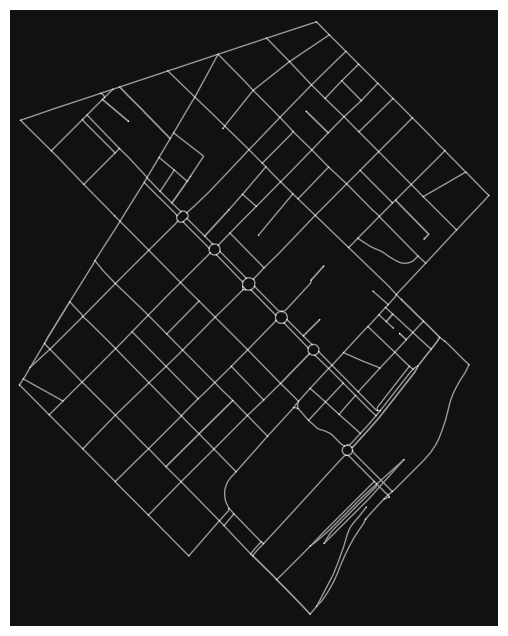

(237, 76)

In [39]:
ox.plot_graph(G, node_size=1)
gdf.shape

In [40]:
# Filter out non-points geometry
gdf_pts = gdf.loc[gdf.geometry.geometry.type=='Point']
gdf_pts.shape
gdf_pts

geometry     amenity  \
element id                                                  
node    660100527    POINT (2.19677 41.40469)        cafe   
        660100529    POINT (2.19419 41.40486)        cafe   
        660771772     POINT (2.19776 41.4035)   fast_food   
        660778771     POINT (2.19865 41.4029)  restaurant   
        660784487     POINT (2.1989 41.40273)  restaurant   
...                                       ...         ...   
        12546429118  POINT (2.19897 41.39577)  restaurant   
        12628316609  POINT (2.20449 41.39877)        cafe   
        12691417681   POINT (2.19818 41.4043)        cafe   
        12837309875  POINT (2.19937 41.40049)        cafe   
        12878647527  POINT (2.19749 41.39907)        cafe   

                                          cuisine             name      shop  \
element id                                                                     
node    660100527                         spanish  Rambla Poblenou  optician   
        660100529                             NaN        El Fornet       NaN   
        660771772                         chicken           Apluma       NaN   
        660778771                         spanish   braseria xorus       NaN   
        660784487                             NaN      La broqueta       NaN   
...                                           ...              ...       ...   
        12546429118                           NaN             Miny       NaN   
        12628316609                           NaN    Repúblic Cafè       NaN   
        12691417681  coffee_shop;breakfast;brunch         Osom Nou       NaN   
        12837309875                           NaN           Labath       NaN   
        12878647527                           NaN        Mono Cafe       NaN   

                    indoor_seating outdoor_seating                   website  \
element id                                                                     
node    660100527              NaN             NaN                       NaN   
        660100529              yes             yes  https://elfornet.com/es/   
        660771772              NaN             NaN   https://www.apluma.com/   
        660778771              yes             yes                       NaN   
        660784487              NaN             NaN                       NaN   
...                            ...             ...                       ...   
        12546429118            NaN             NaN                       NaN   
        12628316609            NaN             NaN                       NaN   
        12691417681            NaN             NaN    https://somososom.com/   
        12837309875            NaN             NaN                       NaN   
        12878647527            yes              no                       NaN   

                    addr:housenumber addr:postcode  ... image payment:cards  \
element id                                          ...                       
node    660100527                NaN           NaN  ...   NaN           NaN   
        660100529                NaN           NaN  ...   NaN           NaN   
        660771772                117         08018  ...   NaN           NaN   
        660778771                105           NaN  ...   NaN           NaN   
        660784487                NaN           NaN  ...   NaN           NaN   
...                              ...           ...  ...   ...           ...   
        12546429118              NaN           NaN  ...   NaN           NaN   
        12628316609               22           NaN  ...   NaN           NaN   
        12691417681              148         08018  ...   NaN           NaN   
        12837309875              NaN           NaN  ...   NaN           NaN   
        12878647527              NaN           NaN  ...   NaN           NaN   

                    name:ro building contact:city contact:housenumber  \
element id                                                  

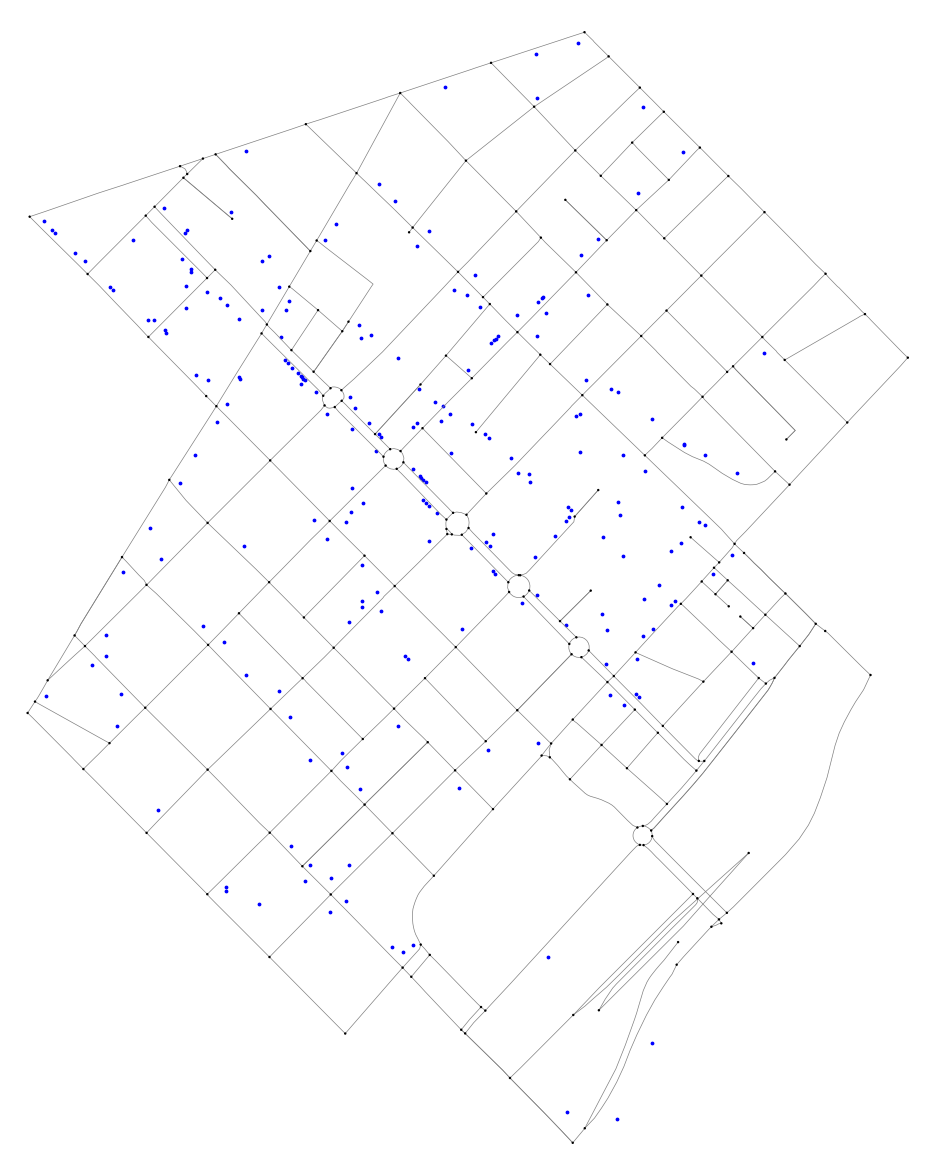

In [41]:
# Start plotting
fig, ax = plt.subplots(figsize=(15, 15))

# Plot GeoDataFrame
gdf_pts.plot(ax=ax, color='blue', markersize=3)

# Draw the graph
ox.plot_graph(G, ax=ax, node_size=3, node_color= "black", edge_linewidth=0.5, edge_color='gray')

plt.show()

In [84]:
import osmnx as ox
import geopandas as gpd
import pandas as pd

place_name = "Poblenou, Barcelona, Spain"

# Download area polygon
place_boundary = ox.geocode_to_gdf(place_name)

# Download all features in the area with broader tags
all_features = ox.features.features_from_polygon(
    place_boundary.geometry.iloc[0],
    tags={"landuse": True, "building": True}
)

# Filter for industrial landuse and warehouse buildings
landuse_industrial = all_features[
    (all_features.get("landuse") == "industrial")
]
building_warehouse = all_features[
    (all_features.get("building") == "warehouse")
]

# Combine into one
smoke_list = pd.concat([landuse_industrial, building_warehouse]).drop_duplicates(subset=["geometry"])
smoke_list.reset_index(drop=True, inplace=True)



In [85]:
nomnom_points = nomnom_list[nomnom_list.geometry.type == "Point"].to_crs(grid.crs)
couch_points = couch_list[couch_list.geometry.type == "Point"].to_crs(grid.crs)
HustleHub_points = HustleHub_list[HustleHub_list.geometry.type == "Point"].to_crs(grid.crs)
smoke_points = smoke_list[smoke_list.geometry.type == "Point"].to_crs(grid.crs)


##spatiotemporal dataset (metadata for each cell)

In [42]:
grid["cell_id"] = range(len(grid))


In [ ]:
buildings = buildings[buildings.geometry.type.isin(['Polygon', 'MultiPolygon'])]


In [46]:
#Relate data to each grid cell
# Spatial join POIs to grid

gdf_pts_proj = gdf_pts.to_crs(grid.crs)

poi_in_cells = gpd.sjoin(gdf_pts_proj, grid, how="inner", predicate="within")
poi_counts = poi_in_cells.groupby("cell_id").size().rename("num_amenities")

# Spatial join streets to grid
streets_in_cells = gpd.overlay(streets, grid, how="intersection")
street_length = streets_in_cells.length.groupby(streets_in_cells["cell_id"]).sum().rename("street_length")

# Spatial join buildings to grid
buildings_in_cells = gpd.overlay(buildings, grid, how="intersection")
building_count = buildings_in_cells.groupby("cell_id").size().rename("num_buildings")


c:\Users\DELL\anaconda3\envs\barcelona_env\Lib\site-packages\geopandas\tools\overlay.py:357: UserWarning: `keep_geom_type=True` in overlay resulted in 6 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)


In [47]:
#Merge these into the grid as metadata
grid = grid.set_index("cell_id")
grid = grid.join([poi_counts, street_length, building_count])
grid = grid.fillna(0).reset_index()


In [48]:
#Add a timestamp
grid["year"] = 2023


##CityGridMetadataBuilder

In [63]:
import geopandas as gpd
import pandas as pd

class CityGridMetadataBuilder:
    def __init__(self, grid: gpd.GeoDataFrame, year: int):
        self.grid = grid.copy()
        self.grid["cell_id"] = range(len(grid))
        self.grid["year"] = year
        self.grid = self.grid.set_index("cell_id")
    
    def add_pois(self, pois, label: str):
        """
        Adds POIs to the grid with a category label, e.g., 'nomnom' → 'num_nomnom'
        """
        joined = gpd.sjoin(pois, self.grid, how="inner", predicate="within")
        counts = joined.groupby("cell_id").size().rename(f"num_{label}")

    # Drop if exists
        if f"num_{label}" in self.grid.columns:
            self.grid = self.grid.drop(columns=[f"num_{label}"])

        self.grid = self.grid.join(counts, how="left").fillna({f"num_{label}": 0})


    def add_streets(self, streets):
    # Reset index to make 'cell_id' a column for spatial operations
        grid_reset = self.grid.reset_index()

        joined = gpd.overlay(streets, grid_reset, how="intersection")
        joined["length"] = joined.length

        if "cell_id" not in joined.columns:
            raise ValueError("cell_id is missing in the result. Check grid indexing.")

        lengths = joined.groupby("cell_id")["length"].sum().rename("street_length")

        if "street_length" in self.grid.columns:
            self.grid = self.grid.drop(columns=["street_length"])

        self.grid = self.grid.join(lengths, how="left").fillna({"street_length": 0})

    def add_buildings(self, buildings: gpd.GeoDataFrame):
        grid_reset = self.grid.reset_index()
        joined = gpd.overlay(buildings, grid_reset, how="intersection")

        if "cell_id" not in joined.columns:
            raise ValueError("cell_id is missing in buildings overlay result.")

        counts = joined.groupby("cell_id").size().rename("num_buildings")

        if "num_buildings" in self.grid.columns:
            self.grid = self.grid.drop(columns=["num_buildings"])

        self.grid = self.grid.join(counts, how="left").fillna({"num_buildings": 0})
    
    def get_grid_with_metadata(self) -> gpd.GeoDataFrame:
        return self.grid.reset_index()


Example Usage

In [86]:
builder = CityGridMetadataBuilder(grid=grid, year=2023)

# Add POIs by category
builder.add_pois(nomnom_points, label="nomnom")
builder.add_pois(couch_points, label="couchcounty")
builder.add_pois(HustleHub_points, label="HustleHub")
builder.add_pois(smoke_points, label="smokestackland")

# Optional: Add streets and buildings if you want
builder.add_streets(streets)
builder.add_buildings(buildings)

metadata_grid = builder.get_grid_with_metadata()



c:\Users\DELL\anaconda3\envs\barcelona_env\Lib\site-packages\geopandas\tools\overlay.py:357: UserWarning: `keep_geom_type=True` in overlay resulted in 6 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)


In [88]:
metadata_grid = builder.get_grid_with_metadata()

# View metadata for cell_id = 42
cell_metadata = metadata_grid[metadata_grid["cell_id"] == 36]
print(cell_metadata)


    cell_id  bbox_west  bbox_south  bbox_east  bbox_north  place_id  osm_type  \
36       36   2.193886   41.391482   2.210803    41.40745  75915407  relation   

     osm_id        lat       lon  ...  \
36  4160731  41.400527  2.201729  ...   

                                         display_name  \
36  el Poblenou, Sant Martí, Barcelona, Barcelonès...   

                                             geometry  num_amenities  year  \
36  POLYGON ((245055.232 5071455.593, 245215.038 5...            7.0  2023   

   num_nomnom num_couchcounty num_HustleHub num_smokestackland  street_length  \
36        7.0             0.0           0.0                0.0     840.237869   

    num_buildings  
36           47.0  

[1 rows x 26 columns]


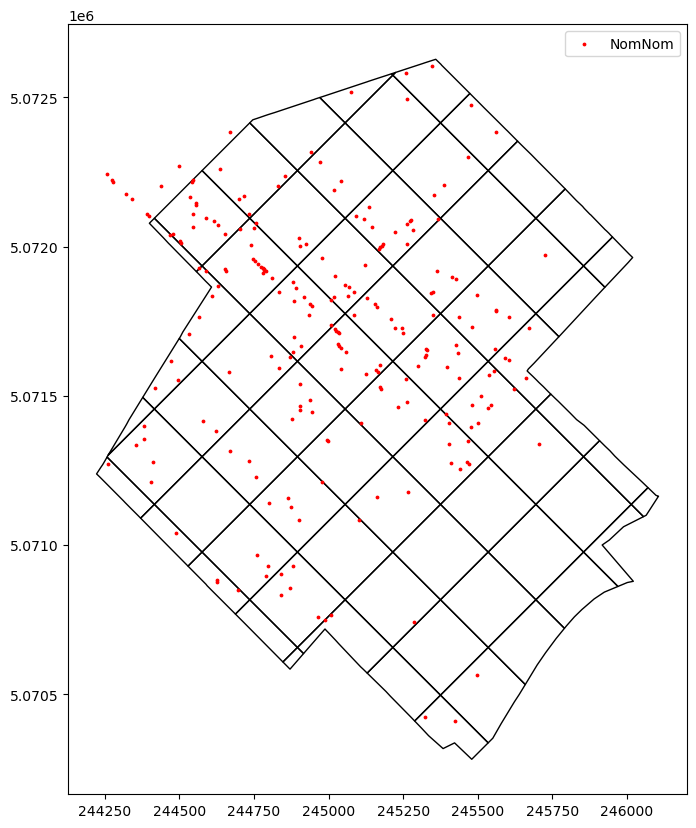

In [89]:
fig, ax = plt.subplots(figsize=(10, 10))
metadata_grid.plot(ax=ax, edgecolor="black", facecolor="none")
nomnom_points.plot(ax=ax, color="red", markersize=3, label="NomNom")
plt.legend()


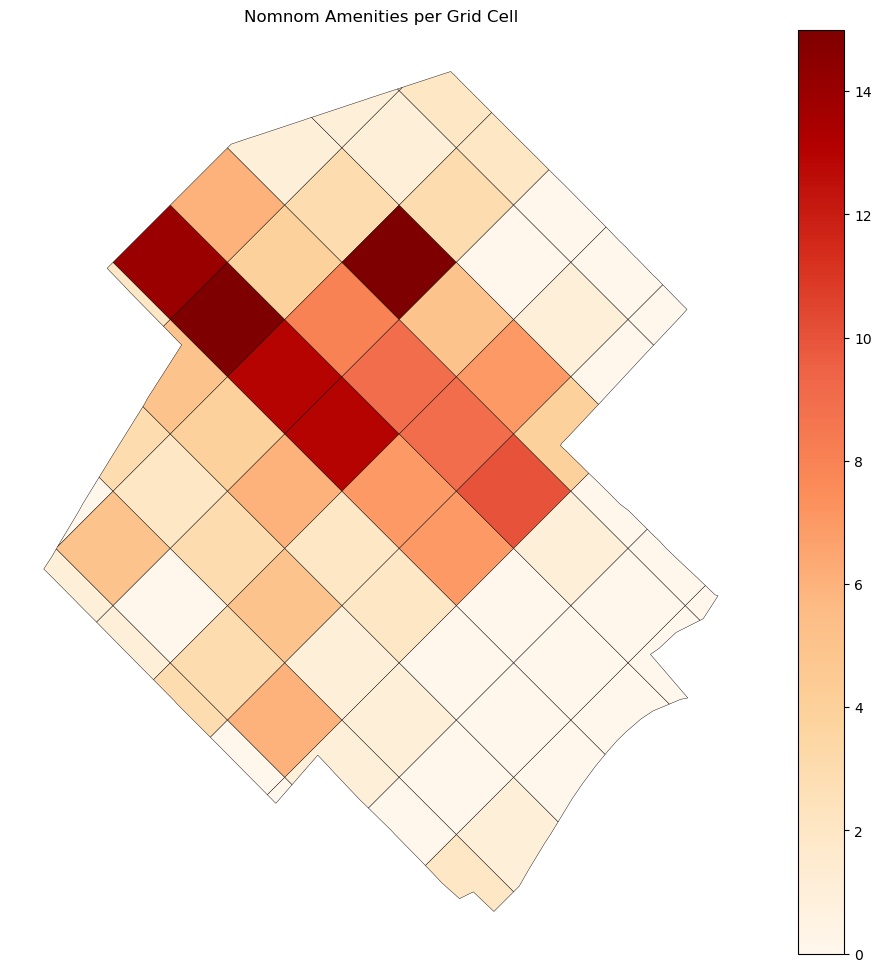

In [90]:
import matplotlib.pyplot as plt

# Plot the grid colored by number of nomnom places
fig, ax = plt.subplots(figsize=(12, 12))
metadata_grid.plot(
    column='num_nomnom',
    ax=ax,
    cmap='OrRd',              # color map: orange-red scale
    legend=True,
    edgecolor='black',
    linewidth=0.3
)
ax.set_title("Nomnom Amenities per Grid Cell")
ax.axis('off')
plt.show()


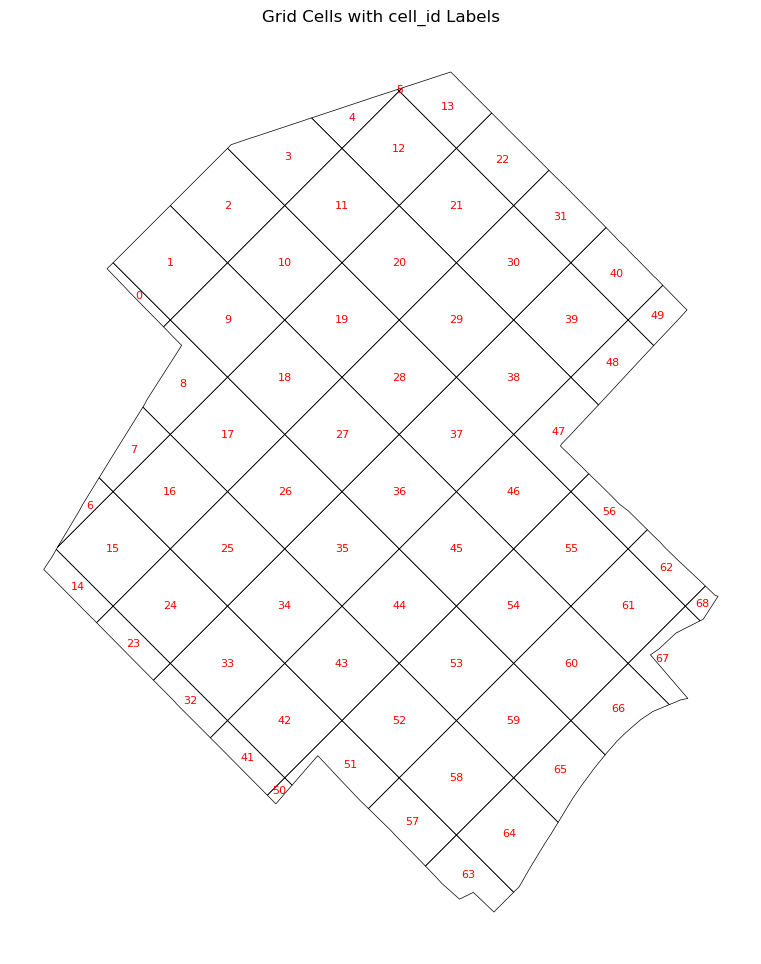

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 12))

# 1. Plot the grid cells
metadata_grid.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.5)

# 2. Add `cell_id` as a label at each grid cell's centroid
for idx, row in metadata_grid.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, str(row.cell_id), 
            ha='center', va='center', fontsize=8, color='red')

# 3. Optional title and remove axis
ax.set_title("Grid Cells with cell_id Labels")
ax.axis('off')
plt.show()


